In [1]:
using Plots
using Plots.PlotMeasures
using LinearAlgebra

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


# Helper functions

In [2]:
#for discrete curves given as [point1,point2..], point1=(x1,y1) etc.

#arclength element at i,
#calculated as average of the distance to previous and distance to next

function ds(X,i)
    n=length(X)
    if i==1
        (norm(X[i]-X[i+1])+norm(X[n]-X[i]))/2
    elseif i==n
        (norm(X[i]-X[i-1])+norm(X[n]-X[1]))/2
    else
        (norm(X[i]-X[i+1])+norm(X[i-1]-X[i]))/2
    end
end

#list the arc length elements
function dslist(X)
    [ds(X,i) for i in 1:length(X)]
end
        
# arclength along X up to the jth vertex.
function arclen(X,j)
    sum([norm(X[i+1]-X[i]) for i in 1:(j-1)])
end

    
#total length
function Len(X)
    n=length(X)
    arclen(X,n)+norm(X[n]-X[1])
end
   ;     

#unit tangent
function utan(X,i)
    n=length(X)
    if i==1
        (X[2]-X[1])/(norm(X[2]-X[1]))
    elseif i==n
        (X[1]-X[n])/(norm(X[1]-X[n]))
    else
        (X[i+1]-X[i])/(norm(X[i]-X[i+1]))
    end
end

function utans(X)
    [utan(X,i) for i in 1:length(X)]
end

rot90=[0 -1 ; 1 0]

function unorms(X)
    [rot90*utan(X,i) for i in 1:length(X)]
end

#area
function Area(X)
    -sum([dot(unorms(X)[i],X[i])*ds(X,i) for i in 1:length(X)])/2
end

# isoperimetric ratio
function ipratio(X)
    (Len(X)^2)/(4*pi*Area(X))
end 


# finds the index where the change in ip ratio between steps gets small
function get_ip_index(X)
    for i in 2:length(X)
        if ipratio(X[i-1])-ipratio(X[i])<=0.001
            return i
            break
        end
    end
    return length(X)
end;

# Plotting functions

In [17]:
        
#change [(xval,yval),(xval,yval)..] to [[xvals],[yvals]]
function split_coords(X)
    [[X[i][1] for i in 1:length(X)],[X[i][2] for i in 1:length(X)]]
end
    
        
#plot steps of the flow on one graph
#takes an list of discrete curves
#skip=2 plots every second curve (time step)
function flow_plot(stepsX,skip)
    Xx=append!(split_coords(stepsX[1])[1],split_coords(stepsX[1])[1][1])
    Xy=append!(split_coords(stepsX[1])[2],split_coords(stepsX[1])[2][1])
    plot(Xx,Xy,ratio=1,key=false,color="black",grid=false,bg_inside=nothing)
    i=1
    while skip*i<length(stepsX)
        Xx=append!(split_coords(stepsX[skip*i])[1],split_coords(stepsX[skip*i])[1][1])
        Xy=append!(split_coords(stepsX[skip*i])[2],split_coords(stepsX[skip*i])[2][1])
        plot!(Xx,Xy,color="black")
        #scatter!(Xx,Xy)
        i=i+1
    end
    plot!() 
end

function flow_series(stepsX,skip)
    numplots=floor(Int,length(stepsX)/skip)+1
    Xx=append!(split_coords(stepsX[1])[1],split_coords(stepsX[1])[1][1])
    Xy=append!(split_coords(stepsX[1])[2],split_coords(stepsX[1])[2][1])
    plot(layout=(1,numplots),link=:all,showaxis=false)
    plot!(Xx,Xy,subplot=1,ratio=1,key=false,color="black",w=1,bg_inside=nothing, ticks=nothing)
    i=1
    while skip*i<=length(stepsX)
        Xx=append!(split_coords(stepsX[skip*i])[1],split_coords(stepsX[skip*i])[1][1])
        Xy=append!(split_coords(stepsX[skip*i])[2],split_coords(stepsX[skip*i])[2][1])
        plot!(Xx,Xy,subplot=i+1,ratio=1,key=false,color="black",w=1,bg_inside=nothing, ticks=nothing)
        #scatter!(Xx,Xy)
        i=i+1
    end
    plot!() 
end

function flow_anim(stepsX)
    N=length(stepsX)
    anim= @animate for i in 1:N
        X=stepsX[1]
        Xx=append!(split_coords(X)[1],split_coords(X)[1][1])
        Xy=append!(split_coords(X)[2],split_coords(X)[2][1])
        plot(Xx,Xy,ratio=1,key=false,axis=false,grid=false,color="white",size=(700,200))
        X=stepsX[i]
        Xx=append!(split_coords(X)[1],split_coords(X)[1][1])
        Xy=append!(split_coords(X)[2],split_coords(X)[2][1])
        plot!(Xx,Xy,ratio=1,key=false,color="black",w=1)
    end
    gif(anim,"./plots/anim_fps30.gif")
end 


#plotting the isoperimetric ratio

function ipr_plot(X)
    plot([ipratio(X[i]) for i in 1:length(X)],
        w=1,
        color="black",
        key=false,
        bg_inside=nothing,
        xticks=false,
        xaxis=false,
        #ylims=(5.5,6.8),
        #yticks=5.0:0.5:6.5,
        grid=false
        )
end

function ipr_plot_comparison(X)
    p1=plot([ipratio(X[1][i]) for i in 1:length(X[1])],key=false,title="isoperimetric ratio")
    scatter!([get_ip_index(X[1])],[ipratio(X[1][get_ip_index(X[1])])])
    for i in 2:length(X)
        plot!([ipratio(X[i][j]) for j in 1:length(X[i])])
        scatter!([get_ip_index(X[i])],[ipratio(X[i][get_ip_index(X[i])])])
    end
    p2=plot([Len(X[1][i]) for i in 1:length(X[1])],key=false,title="length")
    scatter!([get_ip_index(X[1])],[Len(X[1][get_ip_index(X[1])])])
    for j in 2:length(X)
        plot!([Len(X[j][i]) for i in 1:length(X[j])])
        scatter!([get_ip_index(X[j])],[Len(X[j][get_ip_index(X[j])])])
    end
    plot(p1,p2,layout=2)
    end;

# H^1 Gradient flow

In [4]:


# the greens function for H^1 gradient flow
function G(X,i,j)
    s1=arclen(X,i)
    s2=arclen(X,j)
    l=Len(X)
    cosh(abs(s1-s2)-l/2)/(2*sinh(-l/2))
end
        
# build matrix of G
        
function Gmat(X)
    n=length(X)
    Gmatrix=[0.0 for i in 1:n, j in 1:n]
    for i in 1:n
        for j in 1:i
        Gmatrix[i,j]=G(X,i,j)
        Gmatrix[j,i]=Gmatrix[i,j]
        end
    end
    Gmatrix
end

# H^1 gradient flow velocity at the vertex i
function velocity(X,i)
    -X[i]-sum([X[j]*G(X,i,j)*ds(X,j) for j in 1:length(X)])
end
        
# single step of H^1 forward euler with time step h
# saves time not using the velocity function
function step(X,h)
    n=length(X)
    ds=dslist(X)
    Xh=fill([0.0,0.0],n)
    gmatrix=Gmat(X)
    for i in 1:n
        Xh[i]=X[i]-h*(X[i]+sum(X.*gmatrix[i,:].*ds))
    end
    Xh
end
        


# list of N steps of size h
function steps(X,h,N)
    stepsX=[X]
    for i in 1:N
         append!(stepsX,[step(stepsX[end],h)])
    end
    return stepsX
    end;

# Shapes

In [5]:
#square
res=0.05
right=[[1.,y] for y in -1:res:(1-res)]
top=[[-x,1] for x in -1:res:(1-res)]
left=[[-1,-y] for y in -1:res:(1-res)]
bottom=[[x,-1] for x in -1:res:(1-res)]
square=append!(append!(append!(right,top),left),bottom);

# dumbbell
res=0.1
th=0.1
L=4
left=[[cos(x)-L,sin(x)] for x in (0+th):res:(2*pi-th)]
right=[[cos(x)+L,sin(x)] for x in (pi+th):res:(3*pi-th)]
bottom= [[x,-th] for x in -L+1:res:L-1]
top= [[-x,th] for x in -L+1:res:L-1]
dumbbell=append!(append!(append!(left,bottom),right),top);

#limacon
limacon=[(0.5+cos(x))*[cos(x),sin(x)] for x in 0:0.05:2*pi ];

#eight curve (lemniscate of gerono)
eight=[[cos(t),sin(t)*cos(t)] for t in (-pi/2):res:(3*pi/2)];
bigeight=[10*[cos(t),sin(t)*cos(t)] for t in (-pi/2):0.01:(3*pi/2)];


#lemniscate of Bernoulli
lemniscate=[[sqrt(2)cos(t)/(sin(t)^2+1),sqrt(2)cos(t)sin(t)/(sin(t)^2+1)] 
            for  t in (-pi/2):res:(3*pi/2)];

#assymetric lemniscate
right=[[0.5*sqrt(2)cos(t)/(sin(t)^2+1),0.5*sqrt(2)cos(t)sin(t)/(sin(t)^2+1)] 
            for  t in (-pi/2):res:(pi/2)];
left=[[sqrt(2)cos(t)/(sin(t)^2+1),sqrt(2)cos(t)sin(t)/(sin(t)^2+1)] 
            for  t in (pi/2+res):res:(3*pi/2)];
assymetric=append!(left,right);

# bigger assymetric lemniscate
right=[10*[0.5*sqrt(2)cos(t)/(sin(t)^2+1),0.5*sqrt(2)cos(t)sin(t)/(sin(t)^2+1)] 
            for  t in (-pi/2):0.01:(pi/2)];
left=[10*[sqrt(2)cos(t)/(sin(t)^2+1),sqrt(2)cos(t)sin(t)/(sin(t)^2+1)] 
            for  t in (pi/2+res):0.01:(3*pi/2)];
bigassymetric=append!(left,right);

In [6]:
dumb=steps(dumbbell,0.1,100);

┌ Info: Saved animation to 
│   fn = /Users/phil/Dropbox (Personal)/Phil G and V/plots/anim_fps30.gif
└ @ Plots /Users/phil/.julia/packages/Plots/6EMd6/src/animation.jl:104


Plots.AnimatedGif("/Users/phil/Dropbox (Personal)/Phil G and V/plots/anim_fps30.gif")
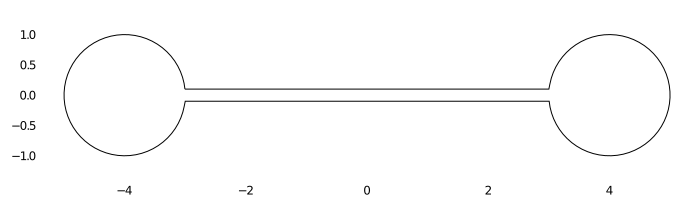

In [18]:
flow_anim(dumb[1:50])

In [15]:
sq=steps(square,0.1,50);

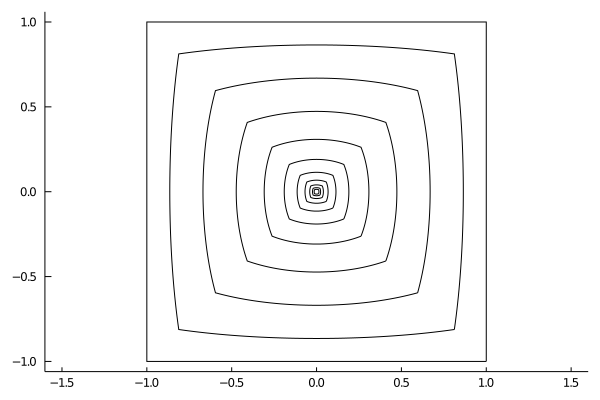

In [16]:
flow_plot(sq,5)